# tnc-edge-network-uptime

This notebook analyses local network performance between the elogs ipad and the edge system.

This notebook also uses at the `internet test` vector for network downtime analysis.

In [1]:
# aws_config = {
# 'aws_access_key_id':'XXXXXXXX',
# 'aws_secret_access_key':'XXXXXXXX',
# 'aws_session_token':'XXXXXXXX'
# }

aws_config = {}

aws_config['profile_name'] ='XXXXXXXX'
aws_config['region_name'] = 'us-east-1'

import boto3

boto3.setup_default_session(**aws_config)

s3 = boto3.client('s3')

# s3.list_objects(Bucket='51-gema-dev-dp-raw' , Prefix='tnc_edge/')

import pandas
import awswrangler
from datetime import datetime, timezone, timedelta
from dateutil import parser
import pytz

def display_full(x):
    pandas.set_option('display.max_rows', 1000)
    pandas.set_option('display.min_rows', 400)
    pandas.set_option('display.max_columns', None)
    pandas.set_option('display.width', 2000)
    pandas.set_option('display.float_format', '{:20,.2f}'.format)
    pandas.set_option('display.max_colwidth', None)
    display(x)
    pandas.reset_option('display.max_rows')
    pandas.reset_option('display.max_columns')
    pandas.reset_option('display.width')
    pandas.reset_option('display.float_format')
    pandas.reset_option('display.max_colwidth')


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [ ]:
branc_dhe = awswrangler.athena.read_sql_query(f"SELECT * from brancol_v1_deckhandevents where datetime > '2024-01-01'", database='tnc_edge')
branc_dhe.datetime = pandas.to_datetime(branc_dhe.datetime, utc=True)
display(branc_dhe)

In [ ]:
stp_dhe = awswrangler.athena.read_sql_query(f"SELECT * from stpatrick_v1_deckhandevents where datetime > '2024-01-01'", database='tnc_edge')
stp_dhe.datetime = pandas.to_datetime(stp_dhe.datetime, utc=True)
display(stp_dhe)

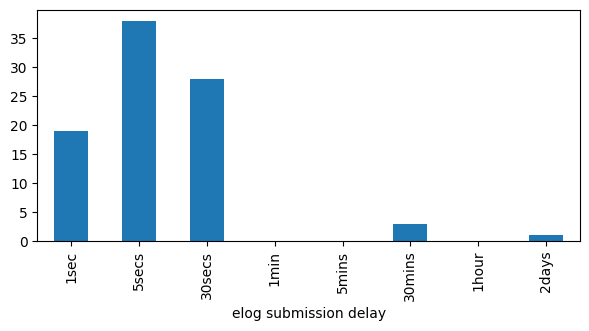

In [4]:
import json

branc_dhe['boat'] = 'brancol'
stp_dhe['boat'] = 'stpatrick'

s = pandas.concat([branc_dhe,stp_dhe])
if 'jsonblob' in s.columns:
    s['json'] = s['jsonblob'].map(json.loads)
    s = s.drop('jsonblob', axis=1)
# display_full(s['json'].loc[s['json'].map(lambda x: x['eventType'] == 'tripDetailsEvent')])

# return
s['jsondatetime'] = s['json'].map(lambda x: x['lastCompletedTimestamp'] if x['eventType'] == 'longlineEvent' \
                                  else x['lastCompletedTimestamp'] if x['eventType'] == 'tripDetailsEvent' else x['eventType'])

s['jsondatetime'] = pandas.to_datetime(s['jsondatetime'].map(lambda x: x*1000000000), utc=True)
s['diff'] = s['datetime'] - s['jsondatetime']



# s['diff'].plot()
binsandlabels = [[timedelta(seconds=0), ''],
                 [timedelta(seconds=1), '1sec'],
                 [timedelta(seconds=5), '5secs'],
                 [timedelta(seconds=30), '30secs'],
                 [timedelta(minutes=1), '1min'],
                 [timedelta(minutes=5), '5mins'],
                 [timedelta(minutes=30), '30mins'],
                 [timedelta(minutes=60), '1hour'],
                 [timedelta(days=2), '2days'],
                ]
bins = [x[0] for x in binsandlabels]
labels = [x[1] for x in binsandlabels][1:]
s['elog submission delay'] = pandas.cut(s['diff'], bins, labels=labels)
s.groupby('elog submission delay').count()['id'].plot(kind='bar', figsize=(7,3))

In [5]:
display_full(s[['boat','datetime', 'jsondatetime','diff']])

,boat,datetime,jsondatetime,diff
0,brancol,2024-02-11 16:32:12.364133+00:00,2024-02-11 16:32:06.192275968+00:00,0 days 00:00:06.171857032
1,brancol,2024-01-13 17:21:37.922640+00:00,2024-01-12 14:46:47.454189056+00:00,1 days 02:34:50.468450944
2,brancol,2024-03-22 16:40:09.398565+00:00,2024-03-22 16:40:08.485693952+00:00,0 days 00:00:00.912871048
3,brancol,2024-01-03 16:52:07.942600+00:00,2024-01-03 16:52:07.303348992+00:00,0 days 00:00:00.639251008
4,brancol,2024-01-16 06:19:29.644317+00:00,2024-01-16 06:19:26.003653888+00:00,0 days 00:00:03.640663112
5,brancol,2024-03-25 16:38:56.678323+00:00,2024-03-25 16:38:55.369782016+00:00,0 days 00:00:01.308540984
6,brancol,2024-03-08 16:48:05.544746+00:00,2024-03-08 16:48:04.790503936+00:00,0 days 00:00:00.754242064
7,brancol,2024-01-22 12:33:43.892537+00:00,2024-01-22 12:33:42.280331008+00:00,0 days 00:00:01.612205992
8,brancol,2024-03-11 16:36:59.849599+00:00,2024-03-11 16:36:59.192934912+00:00,0 days 00:00:00.656664088
9,brancol,2024-02-21 16:01:15.796532+00:00,2024-02-21 16:01:06.625231104+00:00,0 days 00:00:09.171300896


In [18]:
stp_inettests = awswrangler.athena.read_sql_query(f"SELECT id,name,type,vector_id,score,detail,datetime from stpatrick_v1_tests where vector_id = '1' and datetime > '2024-01-01'", database='tnc_edge')
stp_inettests.datetime = pandas.to_datetime(stp_inettests.datetime, utc=True)
stp_inettests['score'] = pandas.to_numeric(stp_inettests['score'])
stp_inettests = stp_inettests.sort_values('datetime')
# display_full(stp_inettests)
stp_inettests

,id,name,type,vector_id,score,detail,datetime
284,6962,internet test at 2024-01-03 13:08:04Z,<NA>,1,0.800000,<NA>,2024-01-03 13:08:04.358730+00:00
285,6969,internet test at 2024-01-03 13:42:31Z,<NA>,1,0.000000,<NA>,2024-01-03 13:42:31.207411+00:00
286,6981,internet test at 2024-01-03 14:12:42Z,<NA>,1,0.000000,<NA>,2024-01-03 14:12:42.966308+00:00
287,6992,internet test at 2024-01-03 14:42:56Z,<NA>,1,0.000000,<NA>,2024-01-03 14:42:56.029891+00:00
283,7004,internet test at 2024-01-03 15:13:07Z,<NA>,1,0.500000,<NA>,2024-01-03 15:13:07.415388+00:00
751,7015,internet test at 2024-01-03 15:43:19Z,<NA>,1,0.000000,<NA>,2024-01-03 15:43:19.446580+00:00
933,7027,internet test at 2024-01-03 16:13:30Z,<NA>,1,0.000000,<NA>,2024-01-03 16:13:30.995058+00:00
934,7036,internet test at 2024-01-03 16:57:31Z,<NA>,1,0.000000,<NA>,2024-01-03 16:57:31.548915+00:00
935,7048,internet test at 2024-01-03 17:27:42Z,<NA>,1,0.666667,<NA>,2024-01-03 17:27:42.373183+00:00
462,7059,internet test at 2024-01-03 17:57:58Z,<NA>,1,0.000000,<NA>,2024-01-03 17:57:58.584857+00:00


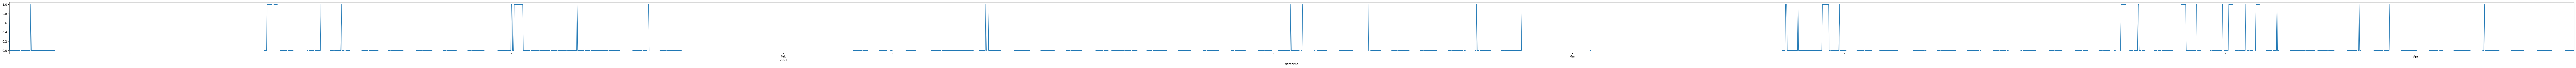

In [25]:
stp_inet_ts = stp_inettests.set_index('datetime')

stp_inet_ts['score'] = stp_inet_ts['score'].apply(lambda x: 0 if x < 0.7 else 1)

stp_inet_ts = stp_inet_ts.resample(timedelta(minutes=30)).first()

stp_inet_ts['score'].plot(figsize=(150,3))

In [20]:
branc_inettests = awswrangler.athena.read_sql_query(f"SELECT id,name,type,vector_id,score,detail,datetime from brancol_v1_tests where vector_id = '1' and datetime > '2024-01-01'", database='tnc_edge')
branc_inettests.datetime = pandas.to_datetime(branc_inettests.datetime, utc=True)
branc_inettests['score'] = pandas.to_numeric(branc_inettests['score'])
branc_inettests = branc_inettests.sort_values('datetime')
# display_full(branc_inettests)
branc_inettests

,id,name,type,vector_id,score,detail,datetime
1749,17996,internet test at 2024-01-03 16:20:39Z,<NA>,1,0.000000,<NA>,2024-01-03 16:20:39.459919+00:00
1750,18008,internet test at 2024-01-03 16:50:50Z,<NA>,1,0.000000,<NA>,2024-01-03 16:50:50.667511+00:00
369,18019,internet test at 2024-01-03 17:21:00Z,<NA>,1,0.000000,<NA>,2024-01-03 17:21:00.590447+00:00
370,18027,internet test at 2024-01-04 15:50:38Z,<NA>,1,0.000000,<NA>,2024-01-04 15:50:38.399991+00:00
371,18039,internet test at 2024-01-04 16:20:48Z,<NA>,1,0.000000,<NA>,2024-01-04 16:20:48.925697+00:00
266,18050,internet test at 2024-01-04 16:50:59Z,<NA>,1,0.000000,<NA>,2024-01-04 16:50:59.657232+00:00
267,18062,internet test at 2024-01-04 17:21:10Z,<NA>,1,0.000000,<NA>,2024-01-04 17:21:10.369318+00:00
190,18069,internet test at 2024-01-05 16:21:21Z,<NA>,1,0.000000,<NA>,2024-01-05 16:21:21.151161+00:00
191,18081,internet test at 2024-01-05 16:51:32Z,<NA>,1,0.000000,<NA>,2024-01-05 16:51:32.030729+00:00
192,18092,internet test at 2024-01-05 17:21:42Z,<NA>,1,0.000000,<NA>,2024-01-05 17:21:42.767611+00:00


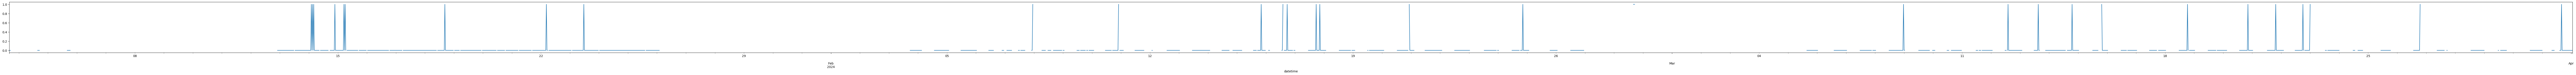

In [26]:
branc_inet_ts = branc_inettests.set_index('datetime')
branc_inet_ts['score'] = branc_inet_ts['score'].apply(lambda x: 0 if x < 0.7 else 1)

branc_inet_ts = branc_inet_ts.resample(timedelta(minutes=30)).first()
branc_inet_ts['score'].plot(figsize=(150,3))

In [33]:
b_len= branc_inettests['score'].notna().sum()
b_sum= branc_inettests['score'].apply(lambda x: 0 if x < 0.7 else 1).sum()
s_len= stp_inettests['score'].notna().sum()
s_sum= stp_inettests['score'].apply(lambda x: 0 if x < 0.7 else 1).sum()

print("b len", b_len)
print("b sum", b_sum)
print("s len", s_len)
print("s sum", s_sum)
print("math", (s_sum + b_sum) / (b_len + s_len))

b len 1846
b sum 33
s len 2178
s sum 105
math 0.03429423459244533
